# Beauty Classifier


In [3]:
# !pip install wget

  Running setup.py bdist_wheel for wget ... done
  Stored in directory: /home/ubuntu/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


# Setup and Helpers

In [5]:
# Imports
%run ../src/utils/helpers.py

from collections import defaultdict
import requests
import boto3
import tempfile
import wget

import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from IPython.display import Image, display, clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [6]:
# Initialization
s3_client = boto3.client('s3')
s3 = boto3.resource('s3')
s3_resource = boto3.resource('s3')
bucket_name = 'eye-of-the-needle'
bucket = s3.Bucket(bucket_name)

Records loaded. 1186 out of 3216 photos have been labeled stunning.

Displaying images scored 0:
['2017/12/25/2017_1225_140000/thumbnail.jpg']


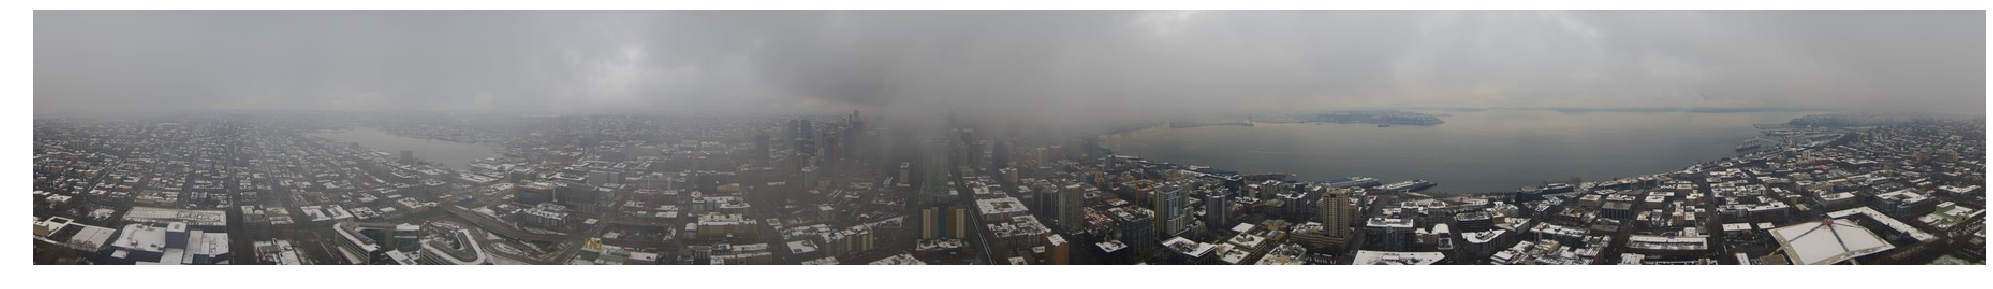

In [4]:
# Helper functions
record_path = '../data/raw/record.pkl'

@load_or_make(record_path, overwrite='n')
def get_record():
    record = defaultdict(dict)
    return record


def display_images(n, score=1):
    record = get_record()
    scores = sum(v['score'] for k, v in record.items())
    print(f"Records loaded. {scores} out of {len(record.keys())} photos have been labeled stunning.")
    l = list(record.keys())

    n_files = []
    while len(n_files) < n:
        f = random.choice(l)
        if record[f]['score'] == score:
            n_files.append(f)

    print(f"\nDisplaying images scored {score}:")
    print(n_files)
    fig = plt.figure(figsize=(35, 12))
    for i, file in enumerate(n_files):
        obj = bucket.Object(file)
        tmp = tempfile.NamedTemporaryFile()
        with open(tmp.name, 'wb') as f:
            obj.download_fileobj(f)
            img=mpimg.imread(tmp.name)
        ax = fig.add_subplot(n, 1, i + 1) 
        ax.imshow(img)
        ax.axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)
    # plt.show()
    return img
n = 1
img = display_images(n, 0)

In [4]:
from IPython.display import Image

fn = '../data/interim/_1130_4528215.png'
display(Image(filename=fn) )

In [5]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

pil_im = Image.open(fn) #Take jpg + png
## Uncomment to open from URL
#import requests
#r = requests.get('https://www.vegvesen.no/public/webkamera/kamera?id=131206')
#pil_im = Image.open(BytesIO(r.content))
im_array = np.asarray(pil_im)
plt.imshow(im_array)
plt.show()

OSError: cannot identify image file '../data/interim/_1130_4528215.png'

In [5]:
img.shape

(237, 1820, 3)

In [3]:
print('hi')

hi


In [4]:
record = get_record()
scores = sum(v['score'] for k, v in record.items())
print(f"Records loaded. {scores} out of {len(record.keys())} photos have been labeled stunning.")
l = list(record.keys())

# n_files = []
# while len(n_files) < n:
#     f = random.choice(l)
#     if record[f]['score'] == score:
#         n_files.append(f)

for file in l:
    obj = bucket.Object(file)
    tmp = tempfile.NamedTemporaryFile()
    with open(tmp.name, 'wb') as f:
        obj.download_fileobj(f)
        img=mpimg.imread(tmp.name)
        if img.shape != (237, 1820, 3):
            print(file)
            print(img.shape)


NameError: name 'get_record' is not defined

# Prep Data

In [10]:
import boto3
import os

from sklearn.model_selection import train_test_split


s3_client = boto3.client('s3')
s3_resource = boto3.resource('s3')

def download_from_s3(prefix, local_path, bucket=bucket_name, client=s3_client, resource=s3_resource):
    keys = []
    dirs = []
    next_token = ''
    base_kwargs = {
        'Bucket': bucket_name,
        'Prefix': prefix,
    }
    while next_token is not None:
        kwargs = base_kwargs.copy()
        if next_token != '':
            kwargs.update({'ContinuationToken': next_token})
        results = s3_client.list_objects_v2(**kwargs)
        contents = results.get('Contents')
        for i in contents:
            k = i.get('Key')
            if k[-1] != '/':
                keys.append(k)
            else:
                dirs.append(k)
        next_token = results.get('NextContinuationToken')
    for d in dirs:
        dest_pathname = os.path.join(local, d)
        if not os.path.exists(os.path.dirname(dest_pathname)):
            os.makedirs(os.path.dirname(dest_pathname))
    for k in keys:
        if not os.path.exists(os.path.dirname(local_path)):
            os.makedirs(os.path.dirname(local_path))
        resource.meta.client.download_file(bucket, k, local_path)
    return


def get_files(data, path):
    local_files = set(os.listdir("../data/imgs/"))
    target_files = set(data['filename'])
    missing = target_files.difference(local_files)
    needed = data[data['filename'].isin(missing)]
    print(f'Getting {len(missing)} files from S3...')
    needed.apply(lambda x: download_from_s3(x['filepath'], path + x['filename']), axis=1)
    print('Success!\n')
    pass


def get_df_from_record():
    record = get_record()
    df = pd.DataFrame.from_dict(record, orient='index').reset_index().sort_values(by='index')
    save_to(df, '../data/raw/df.pkl')
    return df


def process_df(df):
    parse = lambda x: ''.join(x.split('/')[3].split('_'))[:-2]
    date_strings = df['index'].apply(parse)
    filenames = date_strings + 'thumb.jpg'
    df['filename'] = filenames

    df['date'] = pd.to_datetime(date_strings, format='%Y%m%d%H%M', errors='ignore')
    df = df.set_index(pd.DatetimeIndex(df['date'])).drop('date', axis=1)
    df = df.rename(columns={'index': 'filepath'})
    save_to(df, '../data/interim/data.pkl')
    
    df['target'] = df.apply(lambda x: ['fine', 'beautiful'][x['score']], axis=1)
    return df


def run():
    path = '../data/imgs/'
    if 'imgs' not in os.listdir('../data/'):
        os.mkdir('../data/imgs')
    
    df = get_df_from_record()
    data = process_df(df)
    
    train, test = train_test_split(data, test_size=0.2, random_state=42)
    train, val = train_test_split(train, test_size=0.2, random_state=42)
    
    save_to(train, '../data/interim/train.pkl')
    save_to(val, '../data/interim/val.pkl')
    save_to(test, '../data/interim/test.pkl')
    
    proportion = lambda x: x['score'].sum() / x.shape[0]
    msg = lambda x: f'{x.shape[0]} images with {round(100 * proportion(x), 2)}% positive class.'
    print(f'\nTrain set has {msg(train)}')
    print(f'Val set has {msg(val)}')
    print(f'Test set has {msg(test)}\n')
    
    get_files(data, path)
    
    return data

In [11]:
data = run()

Saved file to ../data/raw/df.pkl
Saved file to ../data/interim/data.pkl
Saved file to ../data/interim/train.pkl
Saved file to ../data/interim/val.pkl
Saved file to ../data/interim/test.pkl

Train set has 2057 images with 36.46% positive class.
Val set has 515 images with 36.5% positive class.
Test set has 644 images with 38.51% positive class.

Getting 24 files from S3...
Success!



In [13]:
path = '../data/imgs/'
if 'imgs' not in os.listdir('../data/'):
    os.mkdir('../data/imgs')

record = get_record()
df = pd.DataFrame.from_dict(record, orient='index').reset_index().sort_values(by='index')
df.head()

,index,score,matches
0,2015/01/04/2015_0104_063000/thumbnail.jpg,0,2
1,2015/01/04/2015_0104_064000/thumbnail.jpg,0,2
2,2015/01/05/2015_0105_131000/thumbnail.jpg,0,1
3,2015/01/06/2015_0106_060000/thumbnail.jpg,0,1
4,2015/01/07/2015_0107_002000/thumbnail.jpg,0,2


In [8]:
df[df['score']==0]['matches'].value_counts()

1    1201
2     829
Name: matches, dtype: int64

In [14]:
parse = lambda x: ''.join(x.split('/')[3].split('_'))[:-2]
date_strings = df['index'].apply(parse)
filenames = date_strings + 'thumb.jpg'
df['filename'] = filenames

df['date'] = pd.to_datetime(date_strings, format='%Y%m%d%H%M', errors='ignore')
df = df.set_index(pd.DatetimeIndex(df['date'])).drop('date', axis=1)
df = df.rename(columns={'index': 'filepath'})

df['target'] = df.apply(lambda x: [['fine'], ['beautiful']][x['score']], axis=1)


df.head()

,filepath,score,matches,filename,target
date,,,,,
2015-01-04 06:30:00,2015/01/04/2015_0104_063000/thumbnail.jpg,0,2,201501040630thumb.jpg,[fine]
2015-01-04 06:40:00,2015/01/04/2015_0104_064000/thumbnail.jpg,0,2,201501040640thumb.jpg,[fine]
2015-01-05 13:10:00,2015/01/05/2015_0105_131000/thumbnail.jpg,0,1,201501051310thumb.jpg,[fine]
2015-01-06 06:00:00,2015/01/06/2015_0106_060000/thumbnail.jpg,0,1,201501060600thumb.jpg,[fine]
2015-01-07 00:20:00,2015/01/07/2015_0107_002000/thumbnail.jpg,0,2,201501070020thumb.jpg,[fine]


In [11]:
pd.concat((df, pd.get_dummies(df['target'])), axis=1)

,filepath,score,matches,filename,target,beautiful,fine
date,,,,,,,
2015-01-04 06:30:00,2015/01/04/2015_0104_063000/thumbnail.jpg,0,2,201501040630thumb.jpg,fine,0,1
2015-01-04 06:40:00,2015/01/04/2015_0104_064000/thumbnail.jpg,0,2,201501040640thumb.jpg,fine,0,1
2015-01-05 13:10:00,2015/01/05/2015_0105_131000/thumbnail.jpg,0,1,201501051310thumb.jpg,fine,0,1
2015-01-06 06:00:00,2015/01/06/2015_0106_060000/thumbnail.jpg,0,1,201501060600thumb.jpg,fine,0,1
2015-01-07 00:20:00,2015/01/07/2015_0107_002000/thumbnail.jpg,0,2,201501070020thumb.jpg,fine,0,1
2015-01-07 18:40:00,2015/01/07/2015_0107_184000/thumbnail.jpg,0,1,201501071840thumb.jpg,fine,0,1
2015-01-09 19:10:00,2015/01/09/2015_0109_191000/thumbnail.jpg,0,1,201501091910thumb.jpg,fine,0,1
2015-01-10 12:30:00,2015/01/10/2015_0110_123000/thumbnail.jpg,0,1,201501101230thumb.jpg,fine,0,1
2015-01-14 05:10:00,2015/01/14/2015_0114_051000/thumbnail.jpg,0,1,201501140510thumb.jpg,fine,0,1


In [12]:
len(data)

3216

In [116]:
from sklearn.model_selection import KFold
    
kf = KFold(n_splits=5, random_state=True) # Define the split - into 2 folds 
splits = kf.get_n_splits(X) # returns the number of splitting iterations in the cross-validator


## Extract features from convolutional base

We want to use a solution based on pre-trained models. We will use models that are composed of two parts:

* Convolutional base.
* Classifier.

Our approach will use the convolutional base to extract features, using them to train a classifier to classify the input image as beautiful or not. Therefore, the features extracted from the convolutional base will be the same for all classifiers studied in this example.

Now let's see how to extract features from a convolutional base.

In [13]:
# Imports
import os, shutil, sys

from keras.layers import *
from keras.optimizers import *
from keras.applications import *
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.imagenet_utils import decode_predictions
from keras import backend as k

from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception


Using TensorFlow backend.


In [14]:
def extract_features(data, img_height, img_width, conv_base, batch_size=32):
    sample_count = data.shape[0]
    print(f'Samples: {sample_count}')
    
#     features = np.zeros(shape=(sample_count, 7, 7, 512))  # Must be equal to the output of the convolutional base
    features = np.zeros(shape=(sample_count, 8, 57, 2048))
    labels = np.zeros(shape=(sample_count))

    
    # Preprocess data
    datagen = ImageDataGenerator(rescale=1./255)    
    generator = datagen.flow_from_dataframe(dataframe=data, 
                                            directory='../data/imgs/', 
                                            x_col='filename', 
                                            y_col='target', 
                                            target_size=(img_height, img_width),
                                            class_mode='binary', 
                                            batch_size=batch_size,
                                            save_to_dir='../data/interim/int_imgs/'
                                           )

    
    # Pass data through convolutional base
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
            
    return features, labels


def get_data():
    train = load_from('../data/interim/train.pkl')
    val = load_from('../data/interim/val.pkl')
    test = load_from('../data/interim/test.pkl')

    proportion = lambda x: x['score'].sum() / x.shape[0]
    msg = lambda x: f'{x.shape[0]} images with {round(100 * proportion(x), 2)}% positive class.'
    print(f'\nTrain set has {msg(train)}')
    print(f'Val set has {msg(val)}')
    print(f'Test set has {msg(test)}\n')
    
    return (train, val, test)


def get_model(model, img_height, img_width):
    if model == 'xception':
         conv_base = Xception(weights='imagenet', 
                              include_top=False, 
                              input_shape=(img_height, img_width, 3)) 
     
    elif model == 'inception':
        conv_vase = InceptionV3(weights='imagenet', 
                                include_top=False,
                                input_shape=(img_height, img_width, 3))
    
    elif model == 'vgg':
        conv_base = VGG16(weights='imagenet', 
                          include_top=False,
                          input_shape=(img_width, img_height, 3))
        
    display(conv_base.summary())
    return conv_base


def train_and_predict():
    img_height, img_width = (237, 1820)
    conv_base = get_model('xception', img_height, img_width)
    train, val, test = get_data()
    data = {'train': {'data': train}, 'val': {'data': val}, 'test': {'data': test}}
    for k, v in data.items():
        print(f'Extracting features from {k} dataset')
        v['features'], v['labels'] = extract_features(v['data'], img_height, img_width, conv_base)

    return data


def run():
    results = train_and_predict()
#     save_to(results, '../models/output/results.pkl')
    return results

    

In [15]:
def get_datagen(data, set_name, img_height, img_width, batch_size):
    datagen = ImageDataGenerator(rescale=1. / 255)
    generator = datagen.flow_from_dataframe(dataframe=data,
                                            directory='../data/imgs/', 
                                            x_col='filename', 
                                            y_col='target', 
                                            target_size=(img_height, img_width),
                                            classes=['fine', 'beautiful'],
                                            class_mode='binary', 
                                            batch_size=batch_size)
    return generator


def extract_features(img_height, img_width, conv_base, model_name, batch_size=32):
    # Params
    nb_epoch = 50
    base_model_last_block_layer_number = 116 # based on number of layers in base model (was 126)
    
    # Top Model Block
    x = conv_base.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.2)(x)
#     predictions = Dense(1, activation='nadam')(x)
    predictions = Dense(1, activation='sigmoid')(x)

    # add your top layer block to your base model
    model = Model(conv_base.input, predictions)
    print('Model summary:')
    print(model.summary())

    # Visualize layer names and layer indices to see how many layers/blocks to re-train
    # uncomment when choosing based_model_last_block_layer
    print('Visualizing layer names and indices to see how many layers/blocks to re-train.\n Use to choose base model last block layer.')
    for i, layer in enumerate(model.layers):
        print(i, layer.name)

    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all layers of the based model that is already pre-trained.
    for layer in model.layers:
        layer.trainable = False

    # Read data and get generators
    train, val, test = get_data()

    train_generator = get_datagen(train, 'train', img_height, img_width, batch_size)
    val_generator = get_datagen(val, 'val', img_height, img_width, batch_size)
    
#     lr = 1e-4  # sgd learning rate
    lr = 1e-3  # sgd learning rate
    momentum = .9  # sgd momentum to avoid local minimum
    model.compile(optimizer=SGD(lr=lr, momentum=momentum, decay=0.0, nesterov=False, clipvalue=0.5),
                  loss='binary_crossentropy',
                  metrics=['accuracy'], 
#                   clipvalue=0.5
                 )

    # Save weights of best training epoch: monitor either val_loss or val_acc
    model_path = f'../models/{model_name}/'
    os.makedirs(model_path, exist_ok=True)
    top_weights_path = f'{model_path}top_model_weights.h5'
    callbacks_list = [
        ModelCheckpoint(top_weights_path, monitor='val_acc', verbose=2, save_best_only=True),
        EarlyStopping(monitor='val_acc', patience=5, verbose=0)
    ]

    # Train Simple CNN
    f = 0.5
    weight = {0: f * train['score'].value_counts()[1] / train['score'].sum(), 1: 1.}
    model.fit_generator(train_generator,
                        steps_per_epoch=np.ceil(len(train) / batch_size),
                        epochs=nb_epoch / 5,
                        validation_data=val_generator,
                        validation_steps=np.ceil(len(val) / batch_size),
                        verbose=2,
                        class_weight=weight,
                        callbacks=callbacks_list,
                        use_multiprocessing=True)
    
    # Verbose
    print("\nStarting to Fine Tune Model\n")

    # Add the best weights from the train top model
    # At this point we have the pre-train weights of the base model and the 
    # trained weight of the new/added top model
    # We re-load model weights to ensure the best epoch is selected and not the last one.
    model.load_weights(top_weights_path)

    # Base_model_last_block_layer_number points to the layer in your model you want to train.
    # For example if you want to train the last block of a 19 layer VGG16 model this should be 15
    # If you want to train the last Two blocks of an Inception model it should be 172
    # layers before this number will used the pre-trained weights, layers above and including this number
    # will be re-trained based on the new data.
    for layer in model.layers[:base_model_last_block_layer_number]:
        layer.trainable = False
    for layer in model.layers[base_model_last_block_layer_number:]:
        layer.trainable = True

    # Compile the model with a SGD/momentum optimizer
    # and a very slow learning rate.
    model.compile(optimizer=SGD(lr=lr, momentum=momentum, decay=0.0, nesterov=False, clipvalue=0.5),
                  loss='binary_crossentropy',
                  metrics=['accuracy'], 
#                   clipvalue=0.5
                 )
    # Save weights of best training epoch: monitor either val_loss or val_acc
    final_weights_path = f'{model_path}model_weights.h5'
    callbacks_list = [
        ModelCheckpoint(final_weights_path, monitor='val_acc', verbose=2, save_best_only=True),
        EarlyStopping(monitor='val_loss', patience=5, verbose=0)
    ]

    # Fine-tune the model
    model.fit_generator(train_generator,
                        steps_per_epoch=np.ceil(len(train) / batch_size),
                        epochs=nb_epoch,
                        validation_data=val_generator,
                        validation_steps=np.ceil(len(val) / batch_size),
                        verbose=2,
                        class_weight=weight,
                        callbacks=callbacks_list,
                        use_multiprocessing=True
                       )
    
    # Save model
    model_json = model.to_json()
    with open(f'{model_path}model.json', 'w') as json_file:
        json_file.write(model_json)
    print(f'Model written to {model_path}model.json')
    return


def get_data():
    train = load_from('../data/interim/train.pkl')
    val = load_from('../data/interim/val.pkl')
    test = load_from('../data/interim/test.pkl')

    proportion = lambda x: x['score'].sum() / x.shape[0]
    msg = lambda x: f'{x.shape[0]} images with {round(100 * proportion(x), 2)}% positive class.'
    print(f'\nTrain set has {msg(train)}')
    print(f'Val set has {msg(val)}')
    print(f'Test set has {msg(test)}\n')
    
    return (train, val, test)


def get_model(model_name, img_height, img_width):
    if model_name == 'xception':
        conv_base = Xception(weights='imagenet', 
                             include_top=False, 
                             input_shape=(img_height, img_width, 3))
     
    elif model_name == 'inception':
        conv_base = InceptionV3(weights='imagenet', 
                                include_top=False,
                                input_shape=(img_height, img_width, 3))
    
    elif model_name == 'vgg':
        conv_base = VGG16(weights='imagenet', 
                          include_top=False,
                          input_shape=(img_width, img_height, 3))
        
#     display(conv_base.summary())
    return conv_base


def train_and_predict(model_name):
    img_height, img_width = (237, 1820)
    conv_base = get_model(model_name, img_height, img_width)
    extract_features(img_height, img_width, conv_base, model_name)

    return 


def run():
    model_name = 'xception'
    train_and_predict(model_name)
    k.clear_session()
    return 

    

In [ ]:
run()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model summary:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 237, 1820, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 118, 909, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 118, 909, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1

Loaded file from ../data/interim/val.pkl
Loaded file from ../data/interim/test.pkl

Train set has 2057 images with 36.46% positive class.
Val set has 515 images with 36.5% positive class.
Test set has 644 images with 38.51% positive class.

Found 2057 images belonging to 2 classes.
Found 515 images belonging to 2 classes.
Epoch 1/10
 - 269s - loss: 0.5510 - acc: 0.5506 - val_loss: 0.6690 - val_acc: 0.6330

Epoch 00001: val_acc improved from -inf to 0.63301, saving model to ../models/xception/top_model_weights.h5
Epoch 2/10
 - 254s - loss: 0.5498 - acc: 0.5415 - val_loss: 0.6690 - val_acc: 0.6330

Epoch 00002: val_acc improved from 0.63301 to 0.63301, saving model to ../models/xception/top_model_weights.h5
Epoch 3/10


Seeing no positive results.

Ideas for addressing:
* more data
* one hot encode and do a categorical rather than binary classification
* try different optimizers--adam, or sgd with clipvalue=0.5
* try a sigmoid activation function
* check the probabilities
* dropout layer
* unlock deeper convolutional layers. Maybe an entire additional block?
* could also try training from scratch or looking for other good pre-trained sets

Topic expansion:
* image classification/tagging by weather status: sunny, clear, partly cloudy, cloudy, rainy, snowy, sunset, sunrise, night, pretty, beautiful, stunning

# Interpreting Results

In [5]:
from keras.models import model_from_json

def load_model(name):
    model_path = f'../models/{name}/'

    # Model reconstruction from JSON file
    with open(model_path + 'model.json', 'r') as f:
        model = model_from_json(f.read())

    # Load weights into the new model
    model.load_weights(model_path + 'model_weights.h5')
    return model

Using TensorFlow backend.


In [6]:
model = load_model('xception')

Instructions for updating:
Colocations handled automatically by placer.


In [51]:
img_height, img_width = (237, 1820)
batch_size = 32

train, val, test = get_data()

train_generator = get_datagen(train, 'train', img_height, img_width, batch_size)
val_generator = get_datagen(val, 'val', img_height, img_width, batch_size)

# callbacks_list = [
#     ModelCheckpoint(final_weights_path, monitor='val_acc', verbose=2, save_best_only=True),
#     EarlyStopping(monitor='val_loss', patience=5, verbose=0)
# ]

Loaded file from ../data/interim/train.pkl
Loaded file from ../data/interim/val.pkl
Loaded file from ../data/interim/test.pkl

Train set has 1878 images with 22.74% positive class.
Val set has 470 images with 22.77% positive class.
Test set has 588 images with 21.43% positive class.

Found 1878 images belonging to 2 classes.
Found 470 images belonging to 2 classes.


In [31]:
train_generator.reset()
predictions = model.predict_generator(train_generator, 
                                      steps=np.ceil(len(train) / batch_size),
                                      verbose=1)

pd.DataFrame(predictions)[0].value_counts()

48/48 [==============================] - 151s 3s/step


1.0    1530
Name: 0, dtype: int64

In [23]:
predictions = model.predict_generator(val_generator, 
                                      steps=np.ceil(len(val) / batch_size),
                                      verbose=1)

pd.DataFrame(predictions)[0].value_counts()

12/12 [==============================] - 37s 3s/step


1.0    383
Name: 0, dtype: int64

In [52]:
train_generator.class_indices

{'beautiful': 0, 'fine': 1}

In [40]:
val_generator.class_indices

{'beautiful': 0, 'fine': 1}